# Theoretical Part
---

### 1. Hypothesis Testing – The problem of multiple comparisons [5 points]

The problem of multiple comparisons can be viewed in terms of a Bernoulli experiment over multiple hypothesis tests, in which the Type I Error probability $\alpha$ of each hypothesis test is independent of the previous tests. We treat the probability of Type I Error as the probability of a success in the Bernoulli experiment. Thus, for any one experiment, we have a probability distribtion governed by the following parameters as follows:

* chance of making a Type I Error: $\alpha$
* chance of not making a Type I Error: $1 - \alpha$

Given this setup, a collection of $m$ hypothesis tests generates a binomial distribution for the chance of observing $k$ Type I Errors. The distribution is governed by the following parameters:

* number of trials = $m$
* number of successes = $k$
* probability of Type I Error = $alpha$

The probability mass functions for the binomial distribution is given by:

$$Pr(k\ |\ n, p) = C_n^k p^k (1-p)^{n-k} = \frac{n!}{k!(n-k)!} p^k (1-p)^{n-k}$$

Given this reasoning, we can answer the questions as follows:

$$P(m^{th}\ experiment\ gives\ significant\ result\ |\ m experiments\ lacking\ power\ to\ reject\ H_0) = Pr(Type\ I\ Error) = \alpha$$

$$P(at\ least\ one\ significant\ result\ |\ m\ experiments\ lacking\ power\ to\ reject\ H_0) = Pr(k=1\ |\ n=m, p=\alpha) = \frac{m!}{(m-1)!} \alpha(1-\alpha)^{m-1}$$



### 2. Bias and unfairness in Interleaving experiments [10 points]
A scenario in which a team-draft interleaving algorithm is insensitive between 2 ranked lists of length 4 is detailed in Hoffman et al. (2011). A similar argument is made here for length 3. The scenario is showed in the figure below.

![caption](files/team-draft-interleaving-insensitivity.png)



### References
HOFMANN, K., WHITESON, S., AND DE RIJKE, M. 2011. A probabilistic method for inferring preferences from
clicks. In Proceedings of the ACM Conference on Information and Knowledge Management (CIKM).

# Experimental Part
---

In [1]:
import collections as cl
import itertools
import math
import pickle
import pandas as pd
import numpy as np
from scipy import stats
from copy import deepcopy
from cycler import cycler
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

Pair = cl.namedtuple('Pair', ['P', 'E'])

TRAIN_FILE = "./resources/YandexRelPredChallenge.txt"

### Step 1: Simulate Rankings of Relevance for  E  and  P (5 points)

In [3]:
class Generator():
    """Generator for all possible pairs of rankings.
    
    Args:
        rank_len: Length of each ranking.
        rel_set: Set of relevance scores.
    """
    
    __rank_col = None
    __rank_pairs = None
    
    def __init__(self, length:int=5, rel_set:tuple=(0,1,2)):
        self.rank_len = length
        self.rel_set = rel_set
    
    def generate_rank_col(self)-> None:
        """ Generate collection of all possible rankings.
 
        Returns:
            The cartesian product of `rel_set` repeated `rank_len` times.
        """
        
        self.__rank_col = [x for x in itertools.product(self.rel_set, repeat=self.rank_len)]

    def generate_rank_pairs(self)-> None:
        """ Generate all possible pairs of rankings.

        Returns:
            The cartesian product of a ranking repeated twice.
        """
        
        if self.__rank_col is None:
            self.generate_rank_col()

        self.__rank_pairs = [Pair(*x) for x in itertools.product(self.__rank_col, repeat=2)]
        
    @property
    def rank_col(self):
        if self.__rank_col is None:
            self.generate_rank_col()
            
        return self.__rank_col
    
    @property
    def rank_pairs(self):
        if self.__rank_pairs is None:
            self.generate_rank_pairs()
        
        return self.__rank_pairs


In [4]:
# relevance set {N,R,HR} encoded as tuple (0,1,2)
RANK_LEN = 5
REL_SET = (0,1,2)
MAX_REL = max(REL_SET)
generator = Generator(length=RANK_LEN, rel_set=REL_SET)

In [32]:
generator.rank_pairs

[Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 0, 0)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 0, 1)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 0, 2)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 0)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 1)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 2)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 2, 0)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 2, 1)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 2, 2)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 0, 0)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 0, 1)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 0, 2)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 1, 0)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 1, 1)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 1, 2)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 2, 0)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 2, 1)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 2, 2)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 2, 0, 0)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 2, 0, 1)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 2, 0, 2)),
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 2, 1, 0)),
 Pair(P=(0

### Step 2 :  Implement Evaluation Measures  (10 points)

In [6]:
class OfflineEvaluator():
    """Offline Evaluator for scoring metric: AP, nDCG@k, ERR.
    
    Args: 
        rank_len: Length of each ranking.
        max_rel: Maximum relevance score.
    """
    
    
    def __init__(self, rank_len, max_rel):
        self.rank_len = rank_len
        self.max_rel = max_rel
        self.max_DCG = self.compute_DCG(tuple([max_rel for i in range(rank_len)]))
        self.scores_collection = None
        self.deltas_collection = None
    
    def compute_avg_precision(self, ranking, denominator_R=10):
        """Compute average of precisions at relevant (and highly-relevant) documents.

        Args:
            ranking: Relevance ranking.
            denominator_R: Total relevant (and highly-relevant) documents in collection.
        Returns:
            Tuple with average of precisions of relevant (and highly-relevant) documents.
        """

        R_precision_sum = 0
        R_docs = 0

        for i in range(len(ranking)):
            if ranking[i] >= 1:
                R_docs += 1
                R_precision_sum += R_docs / (i + 1)

        return R_precision_sum / denominator_R

    def compute_DCG(self, ranking, k=None):
        """Compute Discounted Cumulative Gain at rank k.

        Args:
            ranking: Relevance ranking.
            k: Position on which DCG is computed.
        Returns:
            DCG value at rank k.
        """
        
        if k is None:
            k = self.rank_len

        DCG = 0
        for i in range(k):
            DCG += (2 ** ranking[i] - 1) / (math.log2(i + 2))

        return DCG

    def compute_nDCG(self, ranking, k=None):
        """Compute normalized Discounted Cumulative Gain at rank k. 

        Args:
            ranking: Relevance ranking.
            k: Position on which DCG is computed.
            maxDCG: DCG for best possible ranking for normalisation.
        Returns:
            Normalized DCG value at rank k.
        """
        
        if k is None:
            k = self.rank_len

        return self.compute_DCG(ranking, k) / self.max_DCG

    def compute_theta(self, rel):
        """Compute probability of satisfaction.

        Args:
            rel: Relevance score of certain document.
        Returns:
            Probability of satisfaction.
        """
        return (2 ** rel - 1) / (2 ** self.max_rel)

    def compute_ERR(self, ranking):
        """Compute Expected Reciprocal Rank.

        Args:
            ranking: Relevance ranking.
        Returns:
            Expected Reciprocal Rank measure
        """
        p = 1
        ERR = 0

        for i in range(len(ranking)):
            R = self.compute_theta(ranking[i])
            ERR = ERR + p * R / (i + 1)
            p = p * (1 - R)

        return ERR
    
    
    def compute_scores(self, rank_pairs):
        """Computes scores for all pairs in ranking collection

        Args:
            rank_pairs: Collection of ranking pairs
        Returns:
            A set of scores for each pair.
        """
        self.scores_collection = cl.defaultdict(dict)
        
        for pair in rank_pairs:

            self.scores_collection[pair]['AP_P'] = self.compute_avg_precision(pair.P)
            self.scores_collection[pair]['AP_E'] = self.compute_avg_precision(pair.E)

            self.scores_collection[pair]['nDCG_P'] = self.compute_nDCG(pair.P)
            self.scores_collection[pair]['nDCG_E'] = self.compute_nDCG(pair.E)

            self.scores_collection[pair]['ERR_P'] = self.compute_ERR(pair.P)
            self.scores_collection[pair]['ERR_E'] = self.compute_ERR(pair.E)
        
        self.scores_collection = dict(self.scores_collection)
        return self.scores_collection
    
    def compute_deltas(self):
        """Computes deltas for all pairs in ranking collection

        Returns:
            A set of deltas for each pair.
        """
        
        self.deltas_collection = cl.defaultdict(dict)
        
        for pair, score in self.scores_collection.items():
            if score['AP_E'] > score['AP_P']:
                self.deltas_collection[pair]['AP'] = score['AP_E'] - score['AP_P']

            if score['nDCG_E'] > score['nDCG_P']:
                self.deltas_collection[pair]['nDCG'] = score['nDCG_E'] - score['nDCG_P']

            if score['ERR_E'] > score['ERR_P']:
                self.deltas_collection[pair]['ERR'] = score['ERR_E'] - score['ERR_P']
            
        self.deltas_collection = dict(self.deltas_collection)
        
        return self.deltas_collection
    
    @property
    def deltas(self):
        if self.deltas_collection is None:
            raise ValueError('Deltas not computed.')
        
        return self.deltas_collection
    
    @property
    def scores(self):
        if self.scores_collection is None:
            raise ValueError('Scores not computed.')
        
        return self.scores_collection

In [7]:
offline_eval = OfflineEvaluator(rank_len=RANK_LEN, max_rel=MAX_REL)
offline_eval.compute_scores(generator.rank_pairs)

{Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 0, 0)): {'AP_E': 0.0,
  'AP_P': 0.0,
  'ERR_E': 0.0,
  'ERR_P': 0.0,
  'nDCG_E': 0.0,
  'nDCG_P': 0.0},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 0, 1)): {'AP_E': 0.02,
  'AP_P': 0.0,
  'ERR_E': 0.05,
  'ERR_P': 0.0,
  'nDCG_E': 0.04373502583744726,
  'nDCG_P': 0.0},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 0, 2)): {'AP_E': 0.02,
  'AP_P': 0.0,
  'ERR_E': 0.15,
  'ERR_P': 0.0,
  'nDCG_E': 0.13120507751234178,
  'nDCG_P': 0.0},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 0)): {'AP_E': 0.025,
  'AP_P': 0.0,
  'ERR_E': 0.0625,
  'ERR_P': 0.0,
  'nDCG_E': 0.04868944994756881,
  'nDCG_P': 0.0},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 1)): {'AP_E': 0.065,
  'AP_P': 0.0,
  'ERR_E': 0.1,
  'ERR_P': 0.0,
  'nDCG_E': 0.09242447578501607,
  'nDCG_P': 0.0},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 2)): {'AP_E': 0.065,
  'AP_P': 0.0,
  'ERR_E': 0.175,
  'ERR_P': 0.0,
  'nDCG_E': 0.17989452745991058,
  'nDCG_P': 0.0},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 2, 0)): {'AP_E': 0.025

### Step 3 :  Calculate the  𝛥measure (0 points)

In [8]:
offline_eval.compute_deltas()

{Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 0, 1)): {'AP': 0.02,
  'ERR': 0.05,
  'nDCG': 0.04373502583744726},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 0, 2)): {'AP': 0.02,
  'ERR': 0.15,
  'nDCG': 0.13120507751234178},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 0)): {'AP': 0.025,
  'ERR': 0.0625,
  'nDCG': 0.04868944994756881},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 1)): {'AP': 0.065,
  'ERR': 0.1,
  'nDCG': 0.09242447578501607},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 1, 2)): {'AP': 0.065,
  'ERR': 0.175,
  'nDCG': 0.17989452745991058},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 2, 0)): {'AP': 0.025,
  'ERR': 0.1875,
  'nDCG': 0.14606834984270645},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 2, 1)): {'AP': 0.065,
  'ERR': 0.2,
  'nDCG': 0.1898033756801537},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 0, 2, 2)): {'AP': 0.065,
  'ERR': 0.225,
  'nDCG': 0.27727342735504823},
 Pair(P=(0, 0, 0, 0, 0), E=(0, 0, 1, 0, 0)): {'AP': 0.03333333333333333,
  'ERR': 0.08333333333333333,
  'nDCG': 0.05652670087893601},
 Pair(P=(0, 0, 0

### Step 4 :  Implement Interleaving ( 15 points )

In [9]:
class Team_Draft_Interleaving():
    """Interleaves pairs according to team-draft."""
    
    def __init__(self):
        self.rank_i, self.team_e, self.team_p = list(),list(),list()
        self.clicks = {'E': 0, 'P': 0}
    
    def interleave_pairs(self, pair: Pair) -> (list, list, list):
        """Interleaves a pair of rankings using team draft method.

        Args:
            pair: The pair of experimental and production rankings.
        Returns:
            Interleaved ranking and teams  
        """
        rank_e, rank_p = pair.E, pair.P    
        count_e, count_p = 0, 0

        # Algorithm is implemented according to slides, with some simplifications. Because all documents are
        # assumed unique, the checks become simpler. Every time an item from one rank is added to the interleaved result,
        # the item is added to the team and the counter for that list is incremented. When one of the counters reaches the
        # length of its respective ranking, the algorithm stops.
        while count_e < len(rank_e) and count_p < len(rank_p):
            pick_team_e = (len(self.team_e) < len(self.team_p)) or (len(self.team_e) == len(self.team_p) and random.choice((True, False)))
            if pick_team_e:
                self.rank_i.append(rank_e[count_e])
                self.team_e.append(len(self.rank_i)-1)
                count_e += 1
            else:
                self.rank_i.append(rank_p[count_p])
                self.team_p.append(len(self.rank_i)-1)
                count_p += 1
        return self.rank_i[:len(rank_e)], self.team_e, self.team_p
    
    def click(self, index: int):
        """Assign simulated click to the owner of the item.

        Args:
            index: The index of the item clicked.
        """
        
        if index in self.team_e:
            self.clicks['E'] += 1
        elif index in self.team_p:
            self.clicks['P'] += 1
        else:
            raise IndexError('Index {} not in either teams'.format(index))
            
    def reset_clicks_history(self):
        """Reset clicks variable to clear history"""
        self.clicks = {'E': 0, 'P': 0}

### Step 5 :  Implement User Clicks Simulation ( 15 points )

#### 1. Random Click model (RCM)

### $\rho = \frac{\sum_{s\in S}\sum_{u\in s}c_{u}^{(s)}}{\sum_{s\in S}\vert S \vert}$

In other words, $\rho = \frac{ \text{number of clicks}}{\text{number of documents shown}}$

In [10]:
class RCM:
    """Random Click Model training and simulation.
    
    Args:
        log_filename: Path to the training file.
    """
    
    def __init__(self, log_filename):
        log_file = open(log_filename)
        self.probability = self.get_parameters(log_file)
        
    def _is_querry(self, line):
        return line.split()[2].lower() == 'q'

    def _get_url_list(self, line):
        assert line.split()[2].lower() == 'q'
        return line[5:]
    
    def get_parameters(self, training_data):
        """Learn the parameters of the model given a set of training data."""
        documents_shown = 0
        clicks = 0
        for line in training_data:
            if self._is_querry(line): # is querry
                url_list = self._get_url_list(line)
                number_of_urls = len(url_list)
                documents_shown += number_of_urls
            else:# is click
                clicks += 1
        
        return clicks / documents_shown
    
    def click_probabilities(self, urls):
        """Retrieve the click probability given a ranked list of relevance labels.
        (for RCM, all links have the same probability).
        
        Args:
            urls: set of document URLs.
        
        Returns:
            List of click probabilities.
        """
        return [self.probability for i in range(0,len(urls))]
    
    def clicks(self, click_probabilities):
        """Decide - stochastically - whether a document is clicked based on its probabilities.
        
        Args:
            click_probabilities: list of probabilities for each document.
        
        Return:
            List of binary values representing simulated click behaviour.
        """
        return [np.random.binomial(1, prob) for prob in click_probabilities]

In [11]:
rcm_model = RCM(TRAIN_FILE)

#### 2. Simple Dependent Click Model (SDCM)

In [12]:
class SDCM:
    """Simple Dependent Click Model training and simulation.
    
    Args:
        log_filename: Path to the training file.
        max_rel: Maximum relevance score.
    """
    
    def __init__(self, log_filename, max_rel):
        self.max_rel = max_rel
        log_file = open(log_filename)
        self.rank_probabilities = self.get_parameters(log_file)
        self.attractiveness = lambda x: (2**x-1) / 2**self.max_rel
        
    def _is_querry(self, line):
        return line[2].lower() == 'q'

    def _get_url_list(self, line):
        assert line[2].lower() == 'q'
        return line[5:]
    
    def get_rank(self, querry, click):
        if click[3] not in querry[5:]: # weird..
            return -1
        else:
            querry = querry[5:]
            return querry.index(click[3])
    
    def get_parameters(self,training_data):
        """Learn the parameters of the model given a set of training data."""
        last_clicked_rank= -1
        last_querry = -1
        
        last_click_rank_counter = cl.Counter()
        click_rank_counter = cl.Counter()
        
        for line in training_data:
            line = line.split()
            if self._is_querry(line): # is querry
                last_querry = line
                if last_clicked_rank != -1:  #the previusly click was the last one
                    last_click_rank_counter[last_clicked_rank] += 1
                    last_clicked_rank = -1  # we counted it, so we 'remove' it.
            else:# is click
                last_clicked_rank = self.get_rank(last_querry, line)
                click_rank_counter[last_clicked_rank] += 1
        # to take into consideration the last click in the log file.
        if last_clicked_rank != -1:
            last_click_rank_counter[last_clicked_rank] += 1
            last_clicked_rank = -1  # we countend, so we 'remove' it.
            
        return 1 - np.array([last_click_rank_counter[r]/click_rank_counter[r] for r in range(0,10)])
    
    def click_probabilities(self, urls):
        """Retrieve the click probability given a ranked list of relevance labels.
        (for RCM, all links have the same probability).
        
        Args:
            urls: set of document URLs.
        
        Returns:
            List of click probabilities.
        """
        return [self.attractiveness(i) for i in urls]
    
    def clicks(self, atractiveness):
        """Decide - stochastically - whether a document is clicked based on its probabilities.
        
        Args:
            atractiveness: list of probabilities for each document.
        
        Return:
            List of binary values representing simulated click behaviour.
        """
        clicks = np.zeros(len(atractiveness))
        for i, a in enumerate(atractiveness):
            if np.random.binomial(1, a) == 1:
                clicks[i] = 1
                if np.random.binomial(1,self.rank_probabilities[i]) == 0: # we should not contiue
                    break
            else:
                clicks[i] = 0
        return clicks.astype(int).tolist()

In [13]:
sdcm_model = SDCM(TRAIN_FILE, MAX_REL)

### Step 6 :  Simulate Interleaving Experiment ( 10 points )

In [14]:
class Simulator():
    """Simulate interleaving and click experiment.
    
    Args:
        N: Number of trials to repeat experiment.
        pairs: Dicitionary of ranking pairs with offline scores.
    """
    __results = None
    
    def __init__(self, N, pairs):
        self.N = N
        self.rank_pairs = pairs
        
    def simulate_clicks(self, ranking, model, pair):
        """Simulate clicks for one interleaved pair.
    
        Args:
            ranking: Interleaved ranking.
            model: Click model.
            pair: Original relevance ranking pair.
        """
        E_wins = P_wins = 0

        for k in range(self.N):
            clicks = model.clicks(model.click_probabilities(ranking))

            for i, c in enumerate(clicks):
                if c == 1:
                    self.tdi_algorithm.click(i)

            E_score = self.tdi_algorithm.clicks['E']
            P_score = self.tdi_algorithm.clicks['P']

            if E_score > P_score:
                E_wins += 1
            elif P_score > E_score:
                P_wins += 1

            self.tdi_algorithm.reset_clicks_history()
        
        self.rank_pairs[pair][model.__class__.__name__ + '_WE'] = E_wins
        self.rank_pairs[pair][model.__class__.__name__ + '_WP'] = P_wins
        self.rank_pairs[pair][model.__class__.__name__ + '_PE'] = E_wins / (E_wins + P_wins) if E_wins + P_wins != 0 else 0
    
    def run(self):
        """Run simulation experiment."""
        for pair in self.rank_pairs:
            self.tdi_algorithm = Team_Draft_Interleaving()
            interleaved_ranking, _, __ = self.tdi_algorithm.interleave_pairs(pair)
            
            self.simulate_clicks(interleaved_ranking, rcm_model, pair)
            self.simulate_clicks(interleaved_ranking, sdcm_model, pair)
            
    @property
    def results(self):
        if self.__results is not None:
            return self.__results
        
        local = {}
        for p in self.rank_pairs:
            local[pickle.dumps(p)] = self.rank_pairs[p]
        df = pd.DataFrame.from_dict(local, orient='index')
        
        df_std = (df - df.mean())/df.std()
        
        for col in df_std:
            df['s' + col] = df_std[col]
        
        self.__results = df
        
        return self.__results

In [15]:
simulator = Simulator(100, deepcopy(offline_eval.deltas))
simulator.run()

In [16]:
simulator.results

,AP,nDCG,ERR,RCM_WE,RCM_WP,RCM_PE,SDCM_WE,SDCM_WP,SDCM_PE,sAP,snDCG,sERR,sRCM_WE,sRCM_WP,sRCM_PE,sSDCM_WE,sSDCM_WP,sSDCM_PE
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x00K\x00K\x01tq\x02\x86q\x03\x81q\x04.',0.020000,0.043735,0.050000,1,4,0.200000,0,0,0.000000,-1.306083,-1.108096,-1.095018,-1.542173,-0.210500,-1.480429,-2.003563,-1.195299,-2.337856
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x00K\x00K\x02tq\x02\x86q\x03\x81q\x04.',0.020000,0.131205,0.150000,4,4,0.500000,0,0,0.000000,-1.306083,-0.580655,-0.589899,-0.203045,-0.210500,0.003278,-2.003563,-1.195299,-2.337856
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x00K\x01K\x00tq\x02\x86q\x03\x81q\x04.',0.025000,0.048689,0.062500,3,5,0.375000,0,0,0.000000,-1.259570,-1.078221,-1.031878,-0.649421,0.230563,-0.614933,-2.003563,-1.195299,-2.337856
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x00K\x01K\x01tq\x02\x86q\x03\x81q\x04.',0.065000,0.092424,0.100000,2,5,0.285714,0,0,0.000000,-0.887464,-0.814501,-0.842458,-1.095797,0.230563,-1.056513,-2.003563,-1.195299,-2.337856
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x00K\x01K\x02tq\x02\x86q\x03\x81q\x04.',0.065000,0.179895,0.175000,9,5,0.642857,0,0,0.000000,-0.887464,-0.287059,-0.463619,2.028835,0.230563,0.709805,-2.003563,-1.195299,-2.337856
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x00K\x02K\x00tq\x02\x86q\x03\x81q\x04.',0.025000,0.146068,0.187500,2,1,0.666667,0,0,0.000000,-1.259570,-0.491030,-0.400479,-1.095797,-1.533689,0.827560,-2.003563,-1.195299,-2.337856
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x00K\x02K\x01tq\x02\x86q\x03\x81q\x04.',0.065000,0.189803,0.200000,4,6,0.400000,0,0,0.000000,-0.887464,-0.227309,-0.337339,-0.203045,0.671626,-0.491291,-2.003563,-1.195299,-2.337856
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x00K\x02K\x02tq\x02\x86q\x03\x81q\x04.',0.065000,0.277273,0.225000,1,10,0.090909,0,0,0.000000,-0.887464,0.300132,-0.211060,-1.542173,2.435877,-2.019959,-2.003563,-1.195299,-2.337856
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x01K\x00K\x00tq\x02\x86q\x03\x81q\x04.',0.033333,0.056527,0.083333,6,6,0.500000,23,0,1.000000,-1.182048,-1.030963,-0.926645,0.689707,0.671626,0.003278,-1.062889,-1.195299,1.235720
b'\x80\x03c__main__\nPair\nq\x00(K\x00K\x00K\x00K\x00K\x00tq\x01(K\x00K\x00K\x01K\x00K\x01tq\x02\x86q\x03\x81q\x04.',0.073333,0.100262,0.120833,4,6,0.400000,0,0,0.000000,-0.809942,-0.767242,-0.737225,-0.203045,0.671626,-0.491291,-2.003563,-1.195299,-2.337856


### Step 7 :  Results and   Analysis ( 30 points )

In [17]:
class Analysis():
    """Analyse offline and online experiment results.
    
    Args:
        results: Experiment results.
    """
    __sign_binomial_test_p = {}
    __randomization_test = {}
    
    def __init__(self, results):
        self.results = results
        
    def sign_binomial_test(self, click_model):
        df = self.results
    
        successes = len(df[click_model + '_WE'][df[click_model + '_WE'] - df[click_model + '_WP'] > 0])
        trials = len(df[click_model + '_WE'])
        
        self.__proportion_winner_e = successes/trials
        self.__sign_binomial_test_p[click_model] = stats.binom_test(x=successes, n=trials, p=0.5, alternative='greater')
        
        return self.__proportion_winner_e, self.__sign_binomial_test_p[click_model]
        
    def correlation_analysis(self, first_eval, first_eval_name, *the_rest):
        wrong_arguments_message = 'Wrong number of optional arguments! Arguments should come in pairs: .., list, label, ..'
        if len(the_rest)%2 != 0: raise ValueError(wrong_arguments_message)

        first_eval = np.array(first_eval)
        the_rest = np.array(the_rest)

        plt.clf()
        plt.figure(figsize=(8,8))
        colors = [item for item in ['r','g','r', 'b','r', 'y','r', 'm','r', 'c','r', 'k', 'k', 'b']]
        linestyles = [item for item in ['-', '--', ':', '-.', '+', '.','.'] for i in range(2)]
        plt.rc('lines', linewidth=4)
        plt.rc('axes', prop_cycle=(cycler('color',colors) + cycler('linestyle', linestyles)))

        for i in range(0,len(the_rest)):
            if i%2 == 0:
                plt.plot(first_eval, the_rest[i], 'x', zorder=1)
                slope, intercept, _, _, _ = stats.linregress(first_eval, the_rest[i])
                x_vals = np.array(plt.gca().get_xlim())
                y_vals = intercept + slope * x_vals
                plt.plot(x_vals, y_vals,linewidth=3.0, label=the_rest[i+1], zorder=2)

        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


        # LABELS AND TITLE
        plt.xlabel(first_eval_name)
        ylabel = '/'.join([the_rest[i] for i in range(1,len(the_rest)) if i%2 == 1])
        plt.ylabel(ylabel)
        plt.title('Scatter plot of ' + first_eval_name + ' and ' + ylabel)

        plt.show()
    
    def run_randomization(self, list_one, list_two, no_swaps=500):
        if len(list_one) != len(list_two):
            raise ValueError('List should be of the same size!')

        number_of_swaps = no_swaps
        average_differences_list = []
        original_average = np.average(list_two) - np.average(list_one)
        sign = -1 if original_average < 0 else 1

        for i in range(0, number_of_swaps):
            swap_list = np.random.randint(2, size=len(list_one))
            swaped_one = [(1-bit)*list_one[index] + bit*list_two[index] for index, bit in enumerate(swap_list)]
            swaped_two = [bit*list_one[index] + (1-bit)*list_two[index] for index, bit in enumerate(swap_list)]
            average_differences_list.append(sign*(np.average(swaped_two) - np.average(swaped_one)))

        average_differences_list.sort()

        index_in_average_differences_list = np.argmax(average_differences_list >= sign*original_average)

        return index_in_average_differences_list/number_of_swaps  >= 0.95

    def randomization_test(self, offline_index, online_index):
        offline_col = self.results[offline_index].values
        online_col = self.results[online_index].values

        not_nans_indexing = np.invert(np.isnan(offline_col))

        offline_data = deepcopy(offline_col[not_nans_indexing])
        online_data = deepcopy(online_col[not_nans_indexing])

        self.__randomization_test[offline_index + '-' + online_index] = self.run_randomization(offline_data,
                                                                                               online_data)

        return self.__randomization_test[offline_index + '-' + online_index]


In [18]:
analysis = Analysis(simulator.results)

### Sign Test

We first perform a sign test to see how much agreement there is between offline and online evaluation measures. Since we are using only the subpopulation for which at least one offline evaluation metric has resulted in the experimental algorithm (E) being preferred, we would expect a substantial proportion of the pairs to favour E according to online evaluation measures as well. 

The table below shows that the random click model does not agree at all with offline evaluation measures, as there are actually more pairs in which P is the winner. The simple dependent model, is much more in agreement. We can reject the null hypothesis, that the model is indiferent between E and P at a significance level of 1% ($p-value=0.000$), although still in only 70% of the pairs does E emerge as the winner.

It was to be expected that a random click model evaluation would not produce any significant results, since the distribution of clicks is uniform. In effect, this model does not take into account any information about the relevance of the documents, whereas offline measures are constructed with relevance at the center of attention. There are also good reasons for the Simple Dependent Click Model to achieve less than completely agreeable proportion of wins for E, which have to do with the choice of offline metrics used. For example, while nDCG and ERR accomodate graded relevance levels, with ERR making the best efforts in this direction to model user behaviour, AP only treats relevance as binary, so there is no room for emulating nuanced user behaviour. 

|                               | Random Click Model(RCM)     | Simple Dependent Click Model(SDCM)  |
| ----------------------------- |----------------------------:| -----------------------------------:|
| p-value                       | 0.999                       | 0.000                               |
| proportion of wins for E(p)   | 0.444                       | 0.699                               |

In [19]:
analysis.sign_binomial_test('RCM')

(0.44161769047043986, 0.99999999999999989)

In [20]:
analysis.sign_binomial_test('SDCM')

(0.7004535329951963, 0.0)

### Correlation Analysis

We also run a correlation analysis to evaluate agreement between degrees of preference for online and offline evaluation measures. All measures are standardized with a mean of 0 and a standard deviation of 1 of more robust comparisons. Although correlation coefficients (not reported in this work) do not generally achieve high values, the plots below give a better picture. It can be seen that average precision does not correlate in any significant way with Simple Dependent Click Model. Given this discovery, and the previous discussion about the disconenct between binary relevance indicators and nuanced user behaviour, we choose to again exclude average precision for further analysis.

However, a particular trend can be noticed for Discounted Cumulative Gain and Expected Reciprocal Rank. As the offline metric increases, so does the agreement with the online measure. So, when an offline measure is not particularly sure of whether a retrieval algorithm is better than another, (simulated) online behaviour will tend to fluctuate, which is a reasonable observation given the variance in user preferences. However, a strong offlie judgement will tipycally result in convergent online behaviour for both ERR and nDCG.




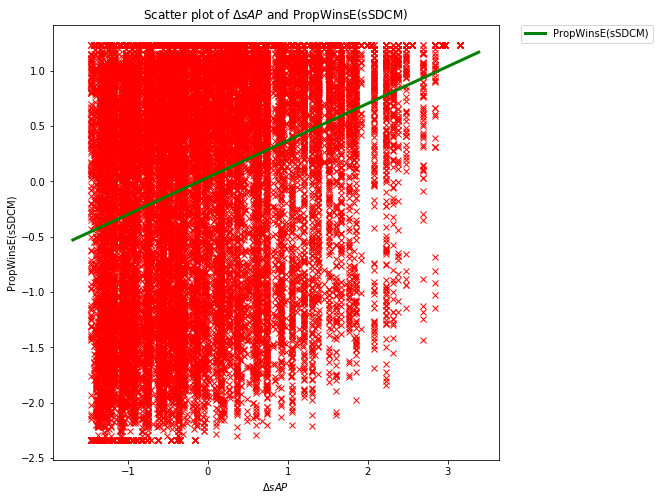

In [31]:
sAP = analysis.results['sAP'][analysis.results['sAP'].notnull()].values
sSDCM_PE = analysis.results['sSDCM_PE'][analysis.results['sAP'].notnull()].values

analysis.correlation_analysis(sAP, r'$\Delta sAP$', sSDCM_PE, 'PropWinsE(sSDCM)')

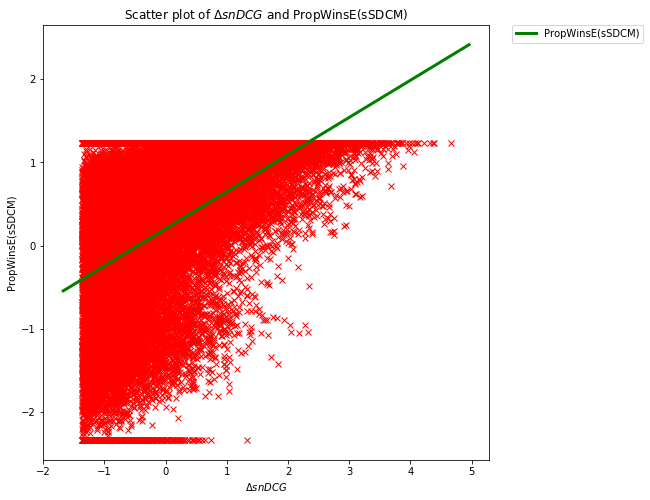

In [29]:
snDCG = analysis.results['snDCG'][analysis.results['snDCG'].notnull()].values
sSDCM_PE = analysis.results['sSDCM_PE'][analysis.results['snDCG'].notnull()].values

analysis.correlation_analysis(snDCG, r'$\Delta snDCG$', sSDCM_PE, 'PropWinsE(sSDCM)')

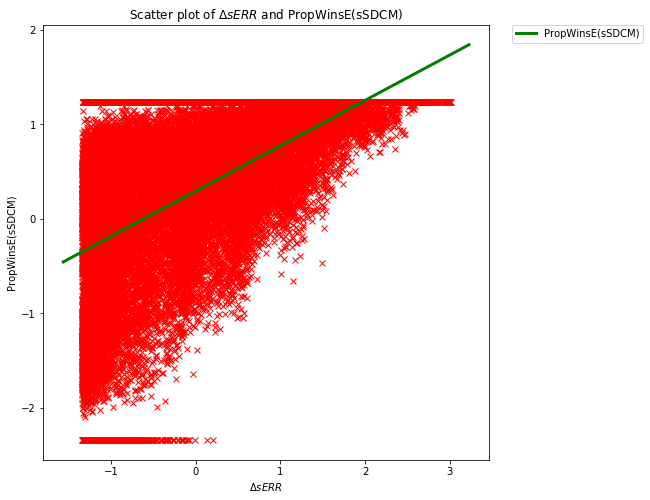

In [30]:
sERR = analysis.results['sERR'][analysis.results['sERR'].notnull()].values
sSDCM_PE = analysis.results['sSDCM_PE'][analysis.results['sERR'].notnull()].values

analysis.correlation_analysis(sERR, '$\Delta sERR$', sSDCM_PE, 'PropWinsE(sSDCM)')

In [24]:
analysis.randomization_test('snDCG', 'sSDCM_PE')

False

In [25]:
analysis.randomization_test('sERR', 'sSDCM_PE')

False